# Lesson 08 - Redes Convolucionais

## Objetivo
Utilizar uma Rede Neural Convolucional para diferenciar entre céu aberto e céu nublado.

## 1. Instalação

In [1]:
!pip install -qqq fastai duckduckgo_search torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 12.1 MB/s eta 0:00:00


In [2]:
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from time import sleep
from PIL import Image
import numpy as np

## 2. Procurando imagens

In [3]:
def search_images(term, max_images=300):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


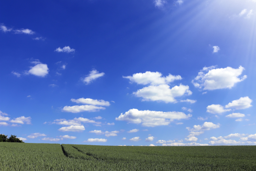

In [4]:
sunny_sky = search_images('sunny sky', max_images=1)[0]
download_url(sunny_sky, 'sunny_sky.jpg', show_progress=False)

Image.open('sunny_sky.jpg').to_thumb(256, 256)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


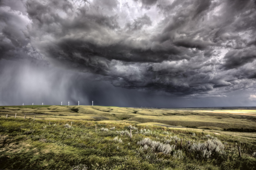

In [6]:
rainy_sky = search_images('rainy_sky', max_images=1)[0]
download_url(rainy_sky, 'rainy_sky.jpg', show_progress=False)

Image.open('rainy_sky.jpg').to_thumb(256, 256)

baixando mais exemplos para usar como a nossa base de dados

In [7]:
searchs = 'rainy sky', 'sunny sky'
path = Path('sky')

for sky in searchs:
    dest = (path/sky)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{sky}'))
    sleep(1)
    resize_images(path/sky, max_size=400, dest=path/sky)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Vamos remover imagens cujo download não foi bem sucedido

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


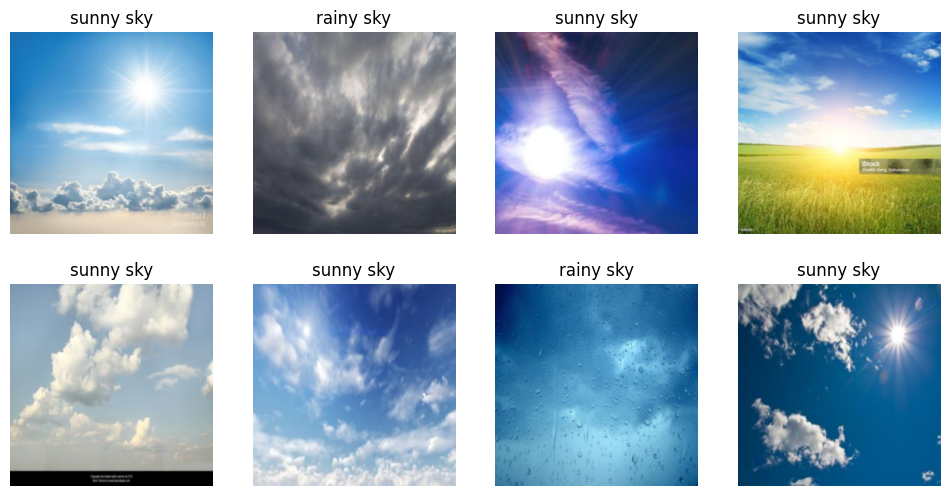

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

## 3. Rede Neural Convolucional


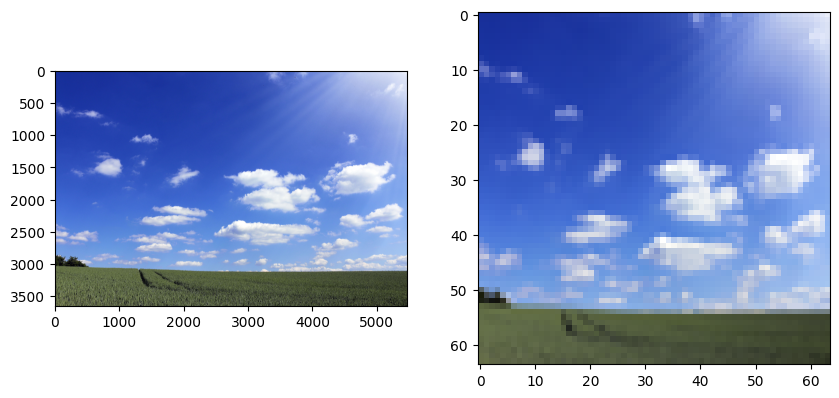

In [11]:
sunny_path = 'sunny_sky.jpg'
sunny = Image.open(sunny_path)

sunny_resized = sunny.resize((64 ,64))

new_sunny = np.asarray(sunny_resized)
initial_sunny = np.asarray(sunny, dtype=np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(initial_sunny)
axs[1].imshow(new_sunny)

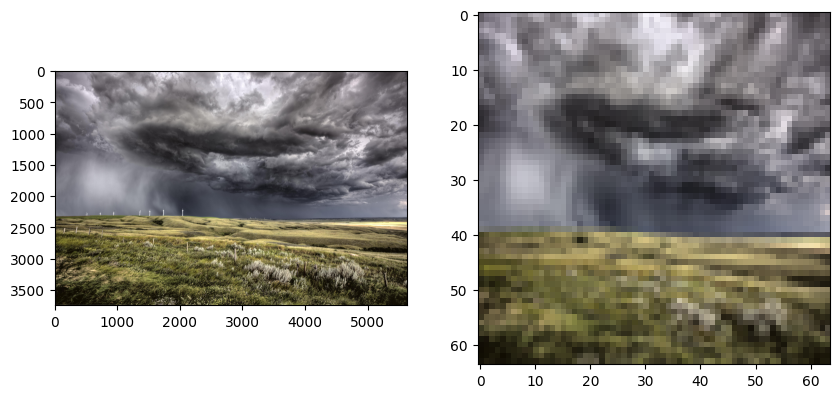

In [12]:
rainy_path = 'rainy_sky.jpg'
rainy = Image.open(rainy_path)

rainy_resized = rainy.resize((64 ,64))

new_rainy = np.asarray(rainy_resized)
initial_rainy = np.asarray(rainy, dtype=np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(initial_rainy)
axs[1].imshow(new_rainy)

Testando filtro de convolução para modificar imagem:

In [22]:
plot = {}
for y in range(3):
    for x in range(3):
        value_x = 23+x
        value_y = 23+y
        plot[f'{value_x}:{value_y}'] = new_sunny[value_x][value_y]

plot

{'23:23': array([ 43,  77, 183], dtype=uint8),
 '24:23': array([ 47,  81, 186], dtype=uint8),
 '25:23': array([ 57,  89, 190], dtype=uint8),
 '23:24': array([ 43,  77, 183], dtype=uint8),
 '24:24': array([ 45,  79, 185], dtype=uint8),
 '25:24': array([ 47,  82, 187], dtype=uint8),
 '23:25': array([ 44,  78, 184], dtype=uint8),
 '24:25': array([ 45,  79, 186], dtype=uint8),
 '25:25': array([ 46,  81, 188], dtype=uint8)}

In [23]:
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[0][0][0] = 0.8
filter_1[0][0][1] = 0.2
filter_1[0][0][2] = 0.8

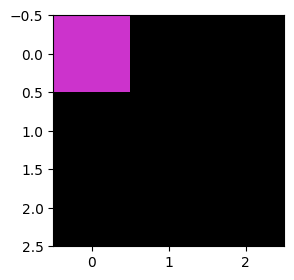

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(filter_1)

In [26]:
img_2 = np.zeros((64,64,3), dtype=float)

for i in range(50):
    for j in range(50):
        img_2[i][j][0] = new_sunny[:,:,0][i][j] * 0.8
        img_2[i][j][1] = new_sunny[:,:,1][i][j] * 0.2
        img_2[i][j][2] = new_sunny[:,:,2][i][j] * 0.8

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(64, 64, 3)

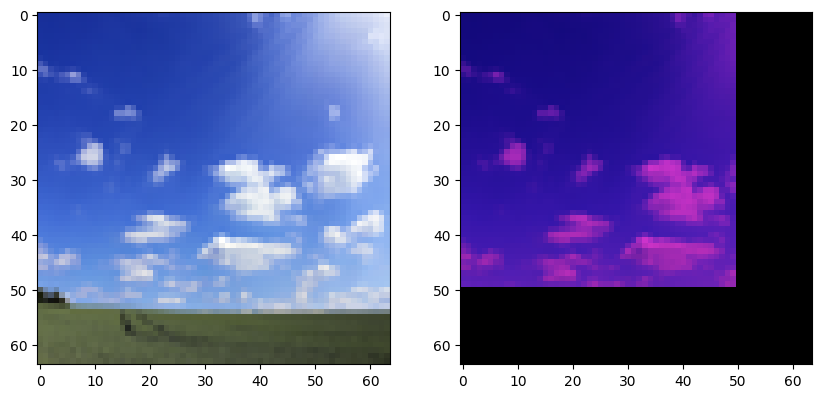

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(new_sunny)
axs[1].imshow(img_2)

Testando modificar nitidez da imagem:

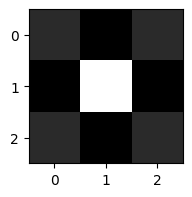

In [28]:
sharpness = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(sharpness, cmap='gray')
plt.show()

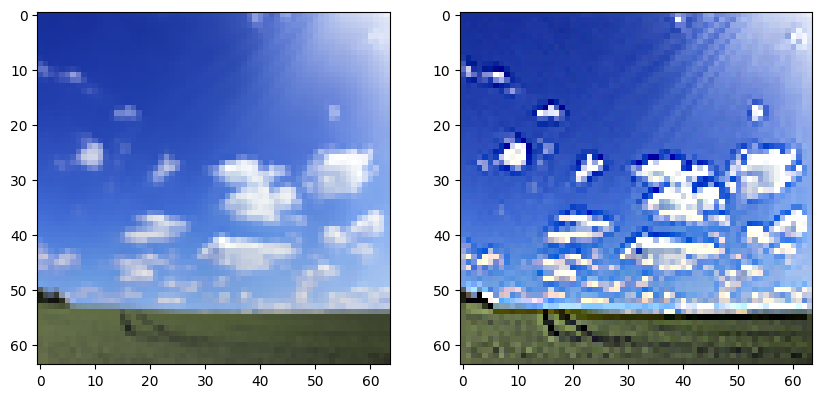

In [29]:
sunny_copy = new_sunny.copy()
height, width, _ = sunny_copy.shape

for color in range(3):
    for i in range(1, height-1):
        for j in range(1, width-1):
            sum = 0
            for ki in range(-1, 2):
                for kj in range(-1, 2):
                    sum += new_sunny[i+ki, j+kj, color] * sharpness[ki+1][kj+1]
            sunny_copy[i, j, color] = min(max(int(sum), 0), 255)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(new_sunny)
axs[1].imshow(sunny_copy)

## 5. Modelo usando resnet

In [32]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 131MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.842046,0.631264,0.322581,0.677419,01:21


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.363337,0.136478,0.064516,0.935484,01:38
1,0.218738,0.023568,0.000000,1.000000,01:37
2,0.156490,0.012787,0.000000,1.000000,01:42


## 6. Testando nos exemplos

In [33]:
# Céu aberto
is_sunny, _, probs = learn.predict(PILImage.create('sunny_sky.jpg'))
print(f"{is_sunny}.")
print(f"Probabilidade: {1 - probs[1]:.4f}")

sunny sky.
Probabilidade: 0.0034


In [34]:
# Céu nublado
is_rainy, _, probs = learn.predict(PILImage.create('rainy_sky.jpg'))
print(f"{is_rainy}.")
print(f"Probabilidade: {probs[1]:.4f}")

rainy sky.
Probabilidade: 0.0000


## 6. Hugging Face

Link: [https://huggingface.co/spaces/fastaioncampus/sunny_or_rainy](https://huggingface.co/spaces/fastaioncampus/sunny_or_rainy)

In [35]:
learn.export('model.pkl')